https://www.kaggle.com/datasets/puneet6060/intel-image-classification?datasetId=111880&sortBy=voteCount

# Intel Image Classification (CNN - Keras)

# Import des packages

In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
from tensorflow import keras
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, Sequential

from tqdm import tqdm

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (64, 64)

# Chargement des données

On doit créer une fonction pour charger les données provenant de différents dossiers

In [3]:
def load_data():
    """
        Load the data:
            - 14,034 images  pour l'entrainement du Réseau de Neurones.
            - 3,000 images pour evaluer la précision du Réseau pour classifier les images
    """
    
    datasets = ['archive/seg_train/seg_train', 'archive/seg_test/seg_test']
    output = []
    
    # Iterer à travers les dossiers train et test
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        print(os.listdir(dataset))
        # Itérer à travers chaque dossier correspondant à chaque catégorie
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate à travers chaque image du dossier en cours
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # On récupère le nom de l'image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # On ouvre et on redimensionne l'image
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # On ajoute l'image et son étiquette correspondante à la sortie
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [4]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading archive/seg_train/seg_train
['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


100%|█████████████████████████████████████| 2274/2274 [00:00<00:00, 4016.40it/s]


Loading archive/seg_test/seg_test
['forest', 'buildings', 'glacier', 'street', 'mountain', 'sea']


100%|███████████████████████████████████████| 510/510 [00:00<00:00, 3995.68it/s]


In [5]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# Exploration du dataset
* Combien d'images avons nous dans le train et le test ?
* Quelle est la taille de chaque image ?
* quelle est la proportion d'image dans chaque catégorie ?

In [6]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (64, 64)


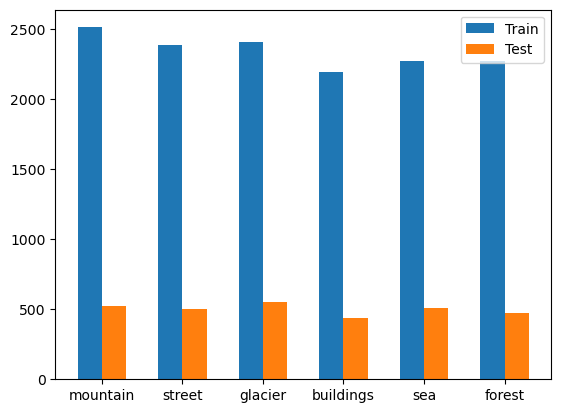

In [7]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)

X_axis = np.arange(len(class_names))
plt.bar(X_axis - 0.15, train_counts, 0.3, label = 'Train')
plt.bar(X_axis + 0.15, test_counts, 0.3, label = 'Test')
plt.xticks(X_axis, class_names)

plt.legend(loc = "best");

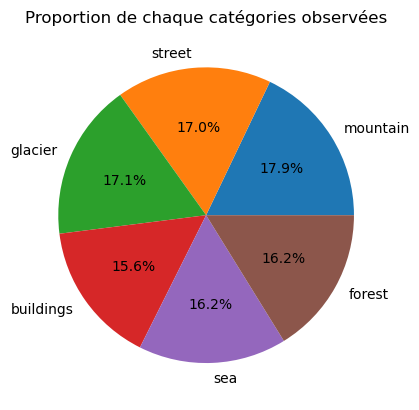

In [8]:
plt.pie(train_counts,
        labels=class_names,
        autopct='%1.1f%%')
plt.title('Proportion de chaque catégories observées')
plt.show()

## Normaliser les images

In [9]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Visualiser les images
On va créer une fonction permettant d'afficher une image aléatoirement

In [10]:
def display_random_image(class_names, images, labels):
    """
        Affiche une image aléatoirement et son étiquette correspondante.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

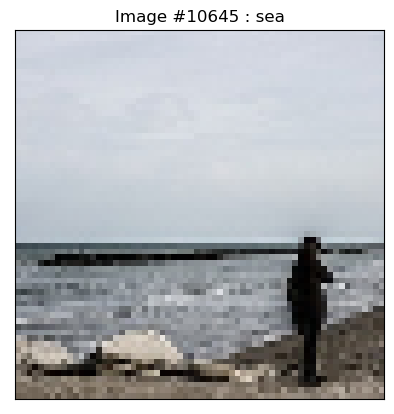

In [11]:
display_random_image(class_names, train_images, train_labels)

On peut aussi afficher les 25 premières images provenant du set d'entrainement

In [12]:
def display_examples(class_names, images, labels):
    """
        Affiche les 25 premières images et leur étiquette corespondante
    """
    
    fig = plt.figure(figsize=(20,20))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

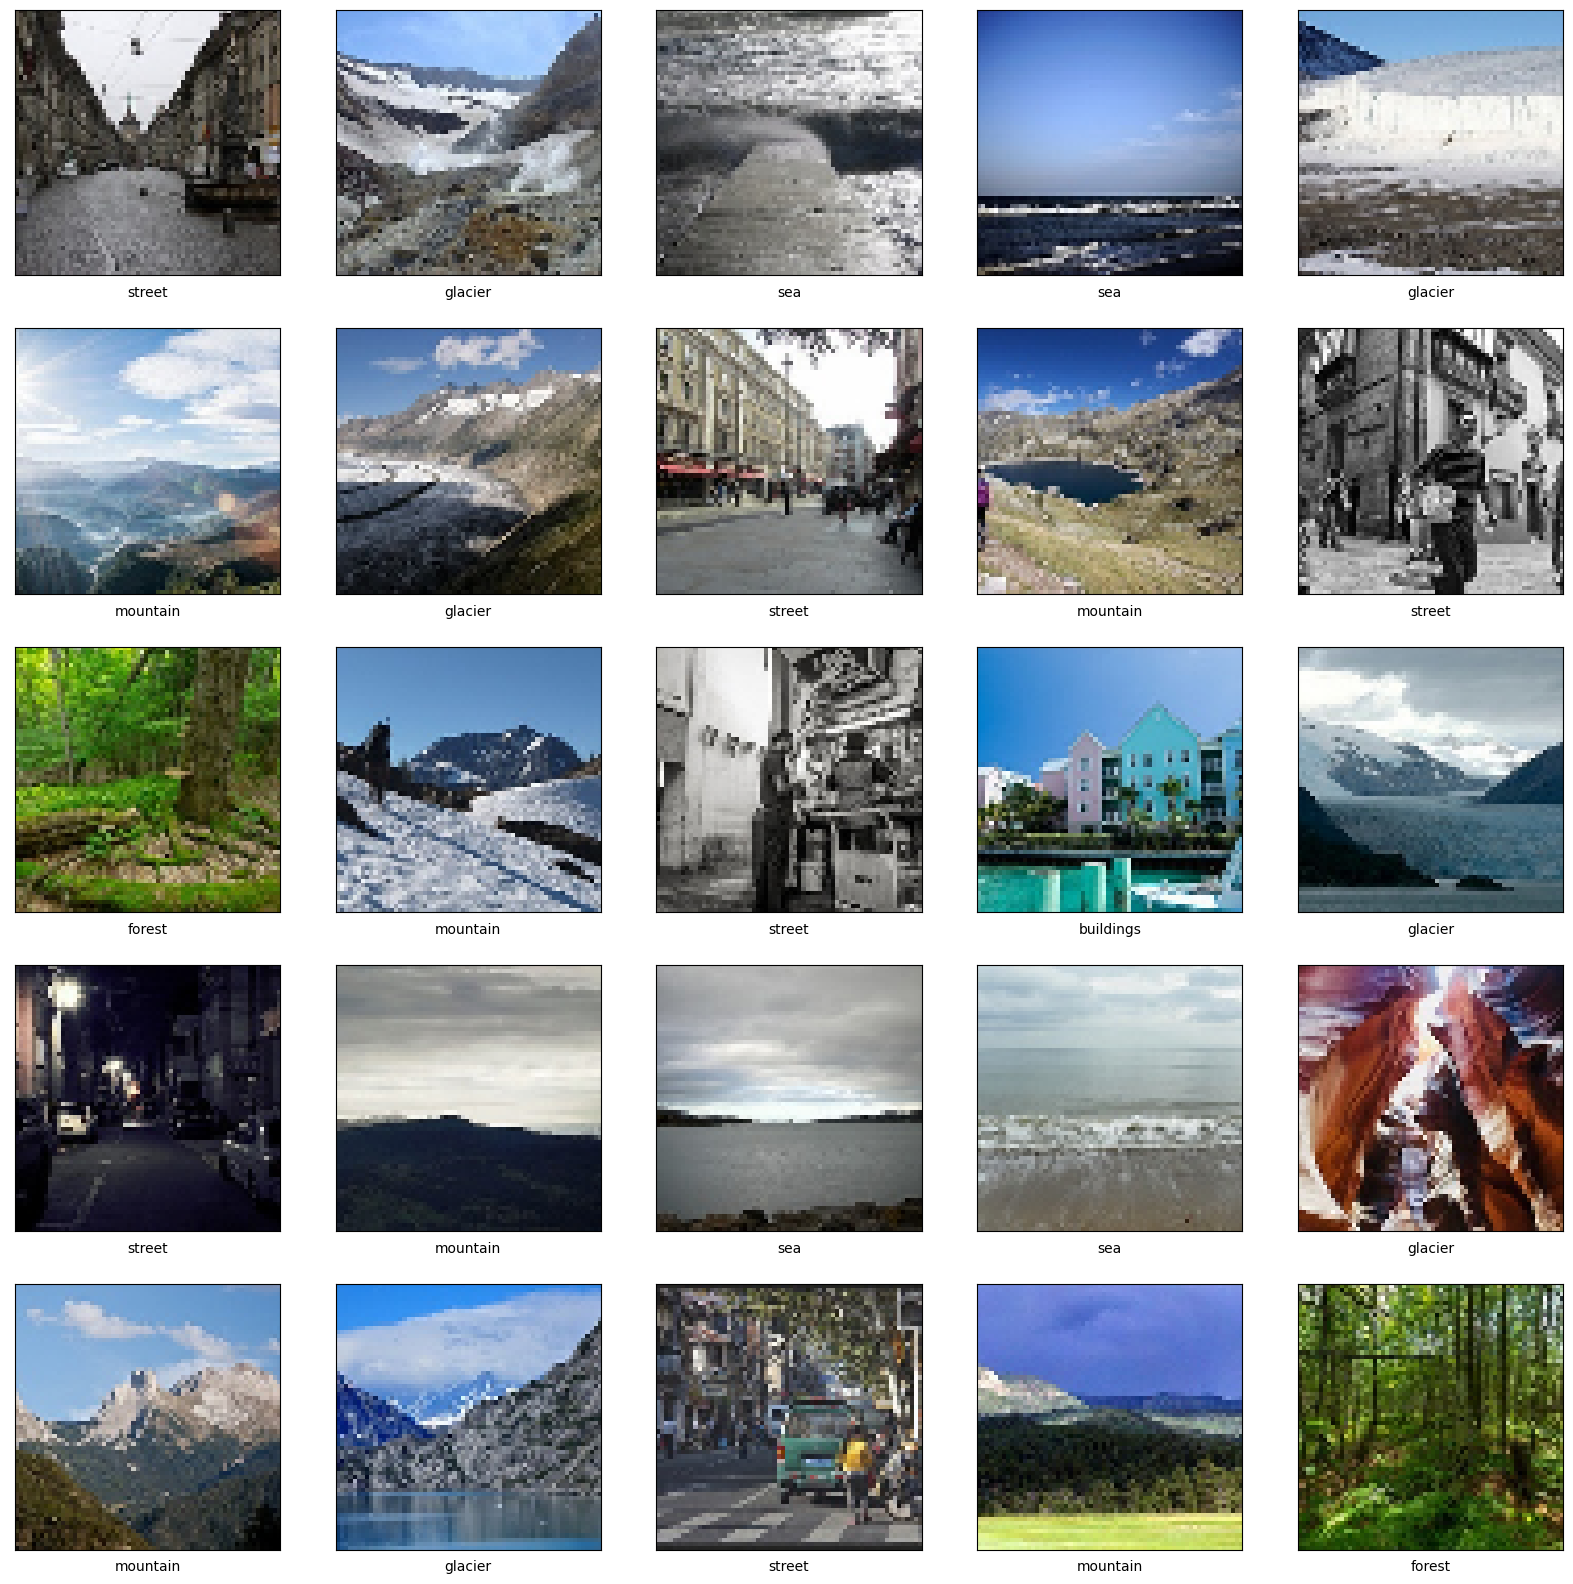

In [13]:
display_examples(class_names, train_images, train_labels)

# Création de modèle simple

Les étapes sont :
* Construire le modèle,
* Compiler le modèle,
* Entraîner / ajuster les données au modèle,
* Évaluer le modèle sur l'ensemble de test,
* Effectuez une analyse d'erreur de notre modèle.

On peut construire un modèle simple en entonnoir composé de différentes couches telles que :
* Conv2D : (32 filtres de taille 3 par 3) Les traits seront "extraits" de l'image.
* MaxPooling2D : les images sont réduites de moitié.
* Aplatir : Transforme le format des images d'un tableau 2d en un tableau 1d de 150 150 valeurs de 3 pixels.
* Relu : étant donné une valeur x, renvoie max(x, 0).
* Softmax : 6 neurones, probabilité que l'image appartienne à l'une des classes.

In [14]:
model = Sequential([
    layers.Conv2D(128,4, activation = 'relu', input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)), 
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, 4, activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, 4, activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(16, 4, activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation= 'relu'),
    layers.Dense(6, activation= 'softmax')
])

Metal device set to: Apple M1


2023-01-29 13:53:44.498730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-29 13:53:44.498950: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 128)       6272      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        131136    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        32800     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 32)         0

In [16]:
model.compile(optimizer = 'adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Ici, le réseau de neurones apprendra par lui-même le motif afin de distinguer chaque catégorie.

In [17]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.25)

Epoch 1/20


2023-01-29 13:53:45.007149: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/Users/emilienbonhomme/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-01-29 13:53:45.212400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 1.4140 - accuracy: 0.3929

2023-01-29 13:53:57.958372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 15s 168ms/step - loss: 1.4140 - accuracy: 0.3929 - val_loss: 1.1773 - val_accuracy: 0.5144
Epoch 2/20
83/83 [==============================] - 14s 165ms/step - loss: 1.1675 - accuracy: 0.5152 - val_loss: 0.9967 - val_accuracy: 0.5942
Epoch 3/20
83/83 [==============================] - 13s 161ms/step - loss: 1.1030 - accuracy: 0.5460 - val_loss: 0.9662 - val_accuracy: 0.6084
Epoch 4/20
83/83 [==============================] - 13s 160ms/step - loss: 1.0095 - accuracy: 0.6011 - val_loss: 1.0581 - val_accuracy: 0.5939
Epoch 5/20
83/83 [==============================] - 13s 159ms/step - loss: 0.9732 - accuracy: 0.6138 - val_loss: 0.8865 - val_accuracy: 0.6495
Epoch 6/20
83/83 [==============================] - 13s 159ms/step - loss: 0.9051 - accuracy: 0.6439 - val_loss: 0.8421 - val_accuracy: 0.6794
Epoch 7/20
83/83 [==============================] - 14s 163ms/step - loss: 0.8777 - accuracy: 0.6643 - val_loss: 0.8288 - val_accuracy: 0.6834
Epoch 8/20

## Comprendre les filtres créés par le CNN

In [18]:
img_building = train_images[train_labels == 3][22]
img_forest = train_images[train_labels == 5][0]
img_glacier = train_images[train_labels == 2][5]
img_mountain = train_images[train_labels == 0][0]
img_sea = train_images[train_labels == 4][0]
img_street = train_images[train_labels == 1][0]


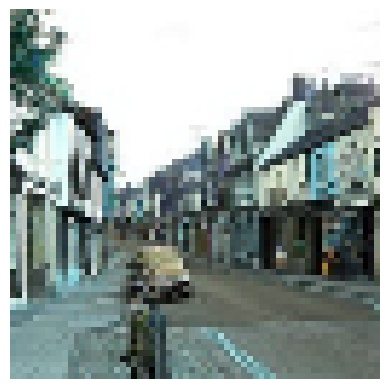

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 71ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:15.208427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 32ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:15.740780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 38ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32


2023-01-29 13:58:16.171829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
2Pooling
1/1 [==============================] - 0s 37ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32


2023-01-29 13:58:16.468028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------


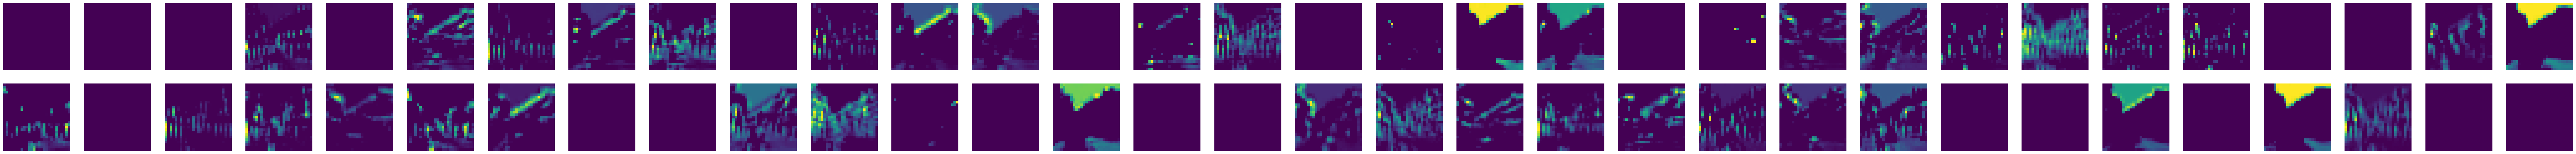

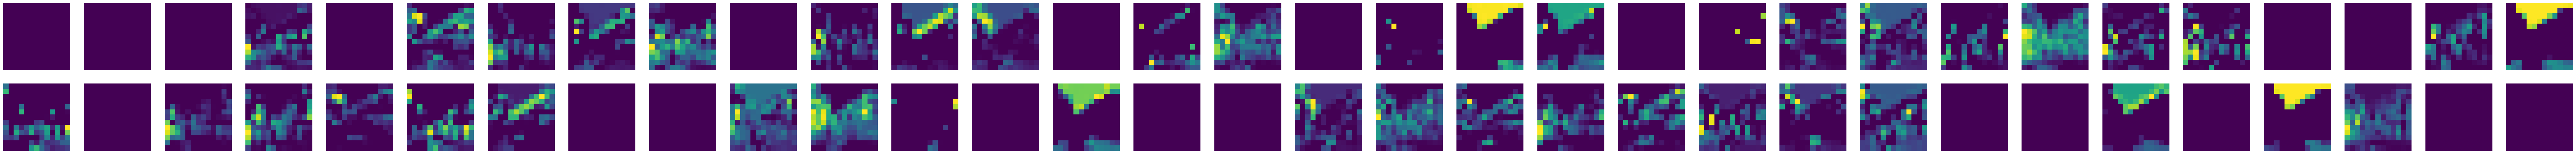

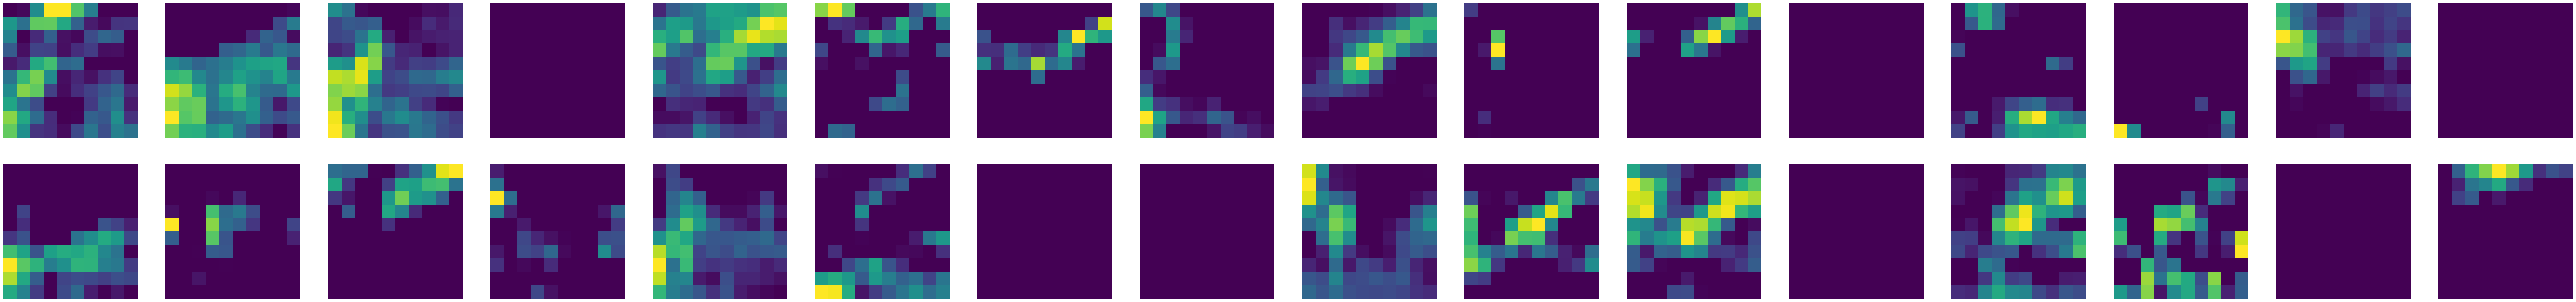

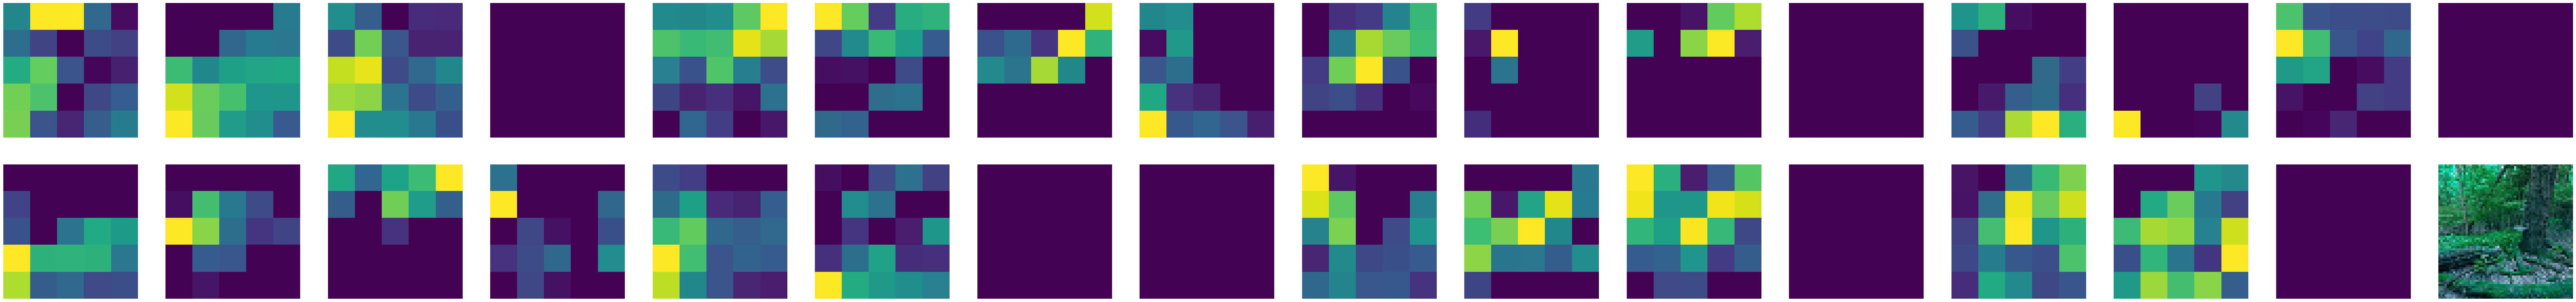

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 32ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:18.851636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 31ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:19.404581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 35ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32
--------
2Pooling


2023-01-29 13:58:19.829894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 39ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32


2023-01-29 13:58:20.031519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------


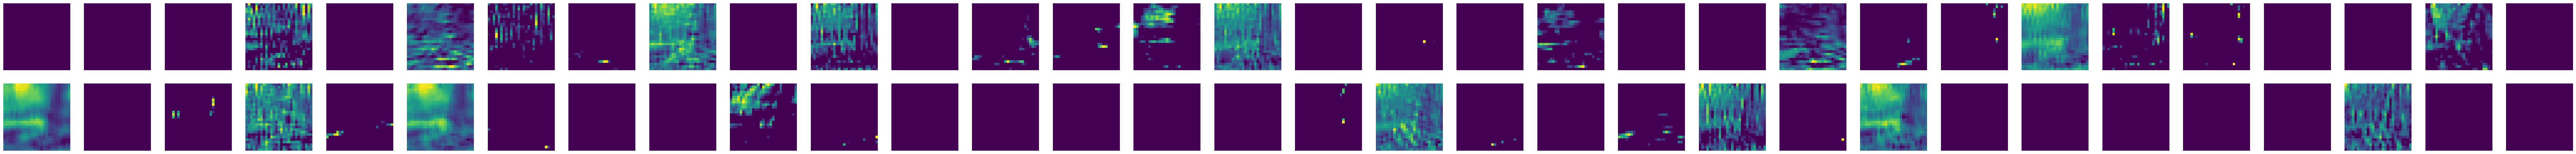

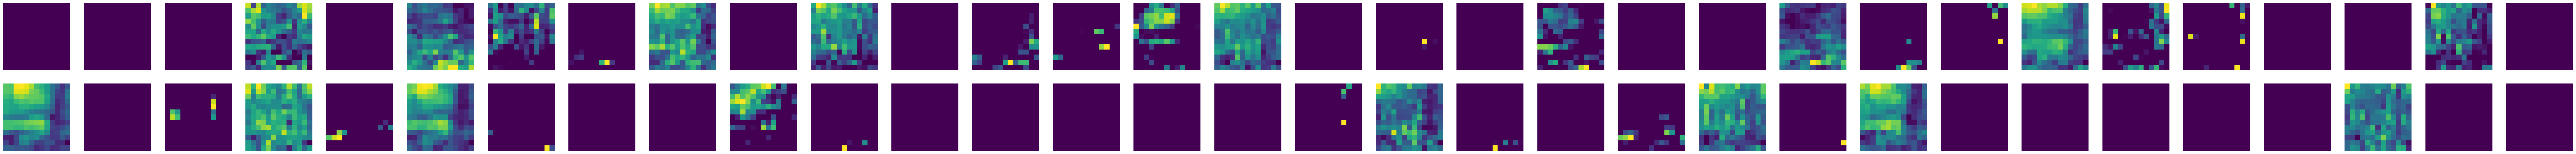

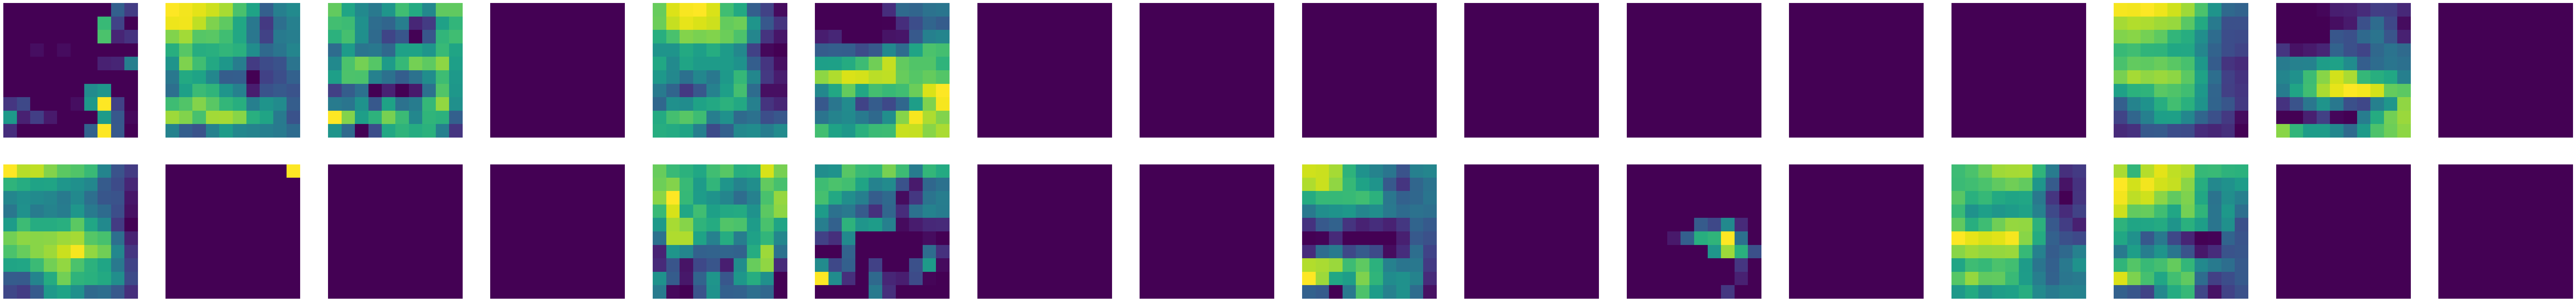

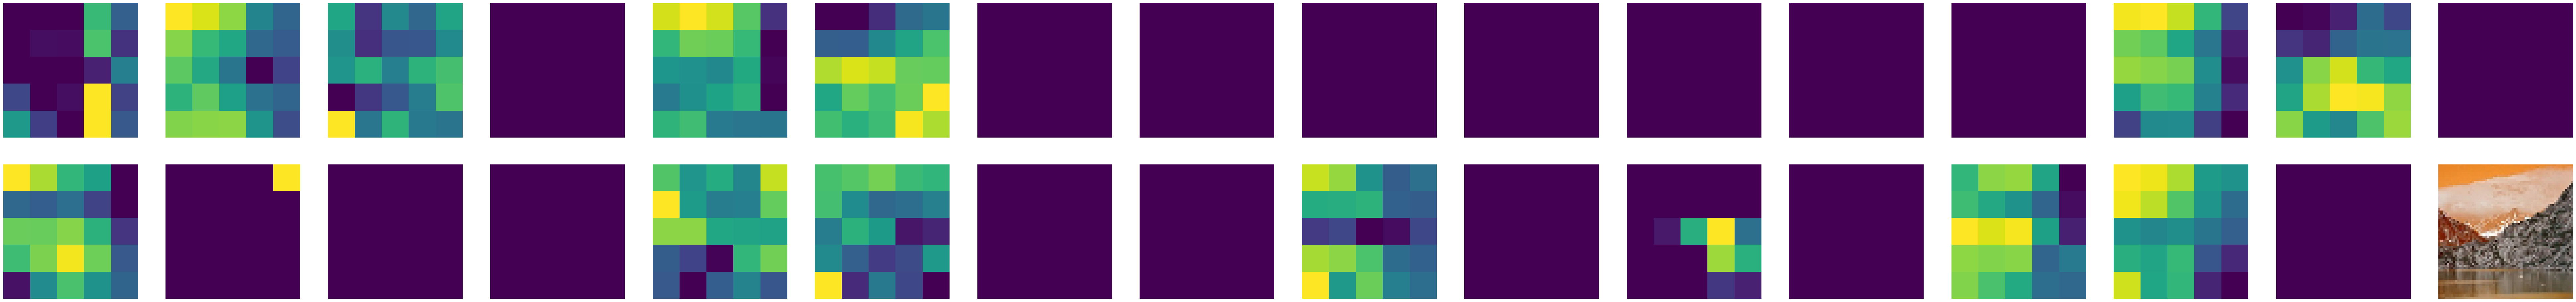

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 33ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:22.182474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 30ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:22.546290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 35ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32


2023-01-29 13:58:23.068964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
2Pooling
1/1 [==============================] - 0s 36ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32
-----------------------------------------------------


2023-01-29 13:58:23.367546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


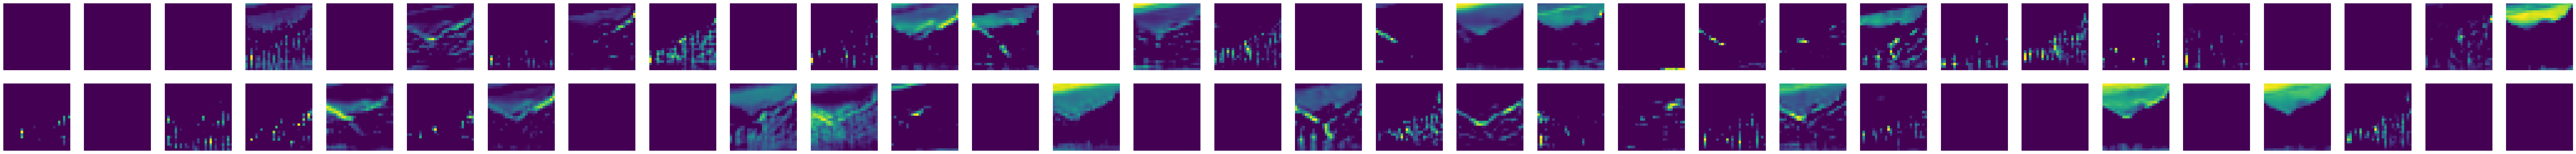

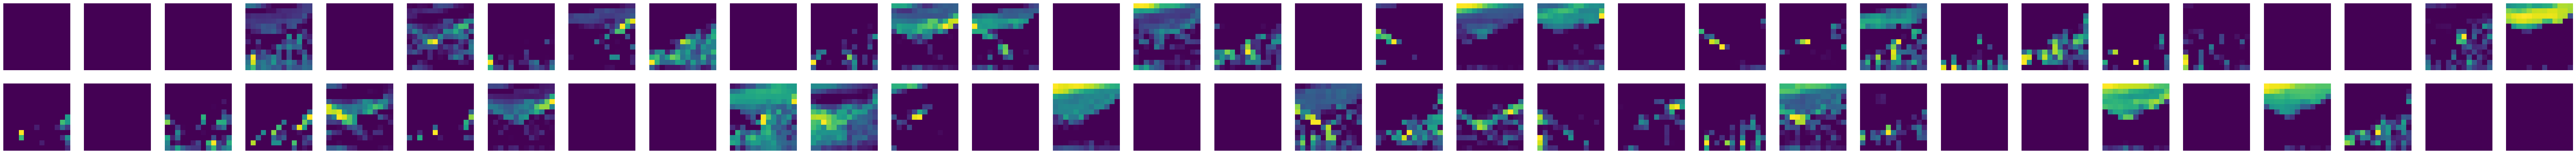

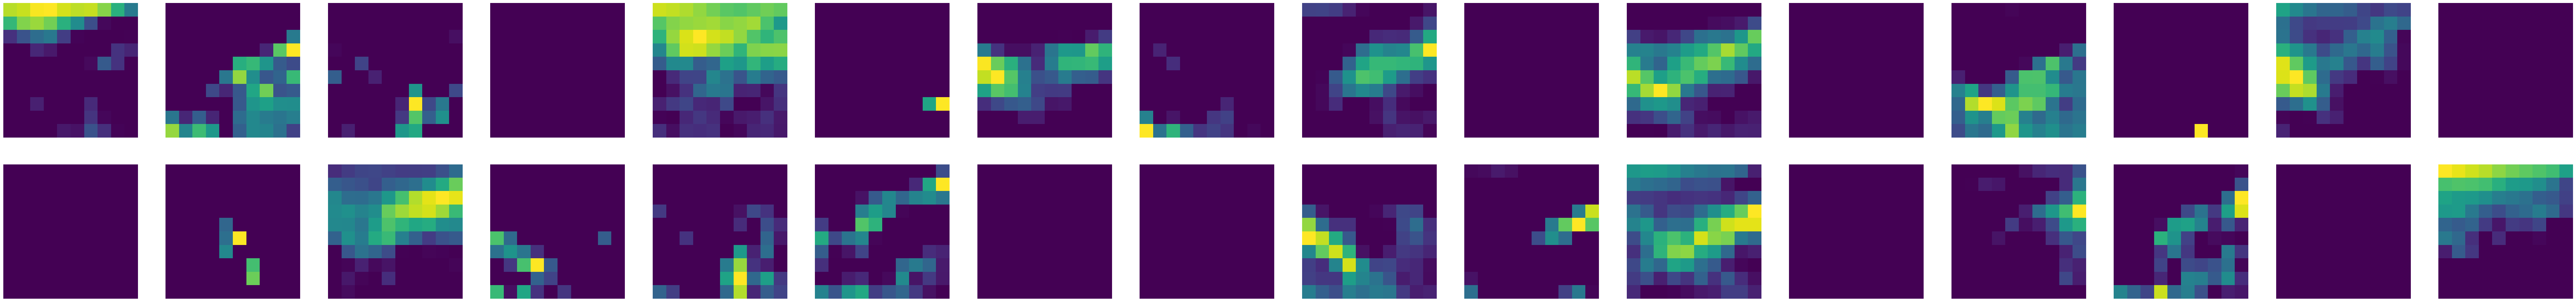

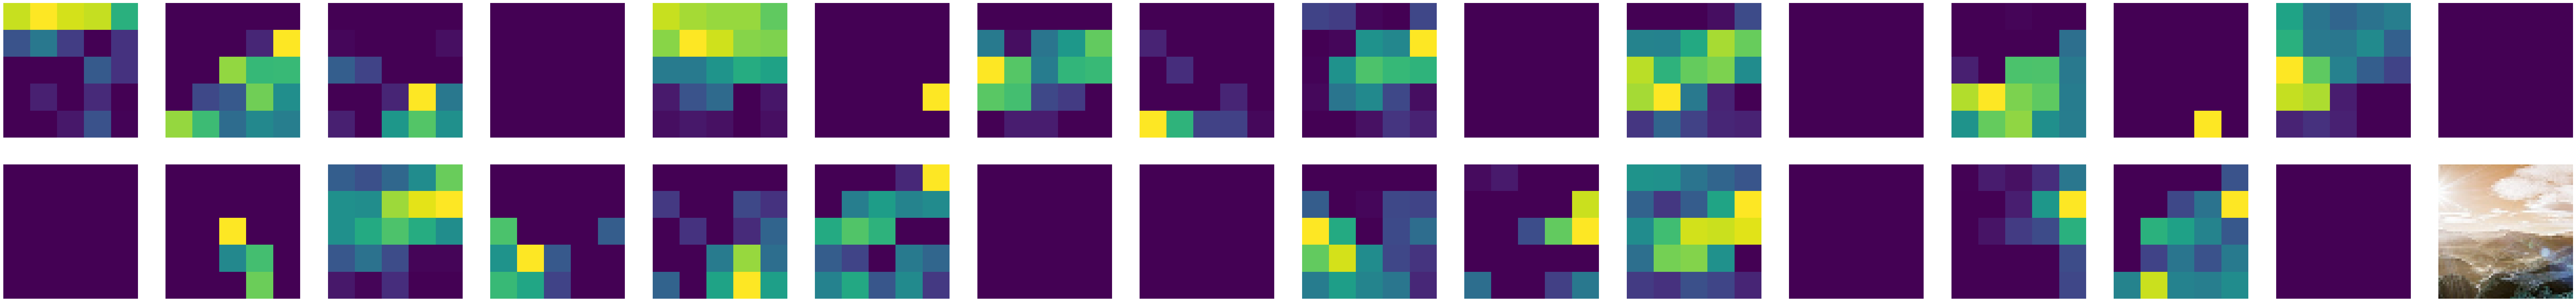

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 33ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:25.581903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 29ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:26.142608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 35ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32
--------
2Pooling


2023-01-29 13:58:26.565480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 13:58:26.762785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32
-----------------------------------------------------


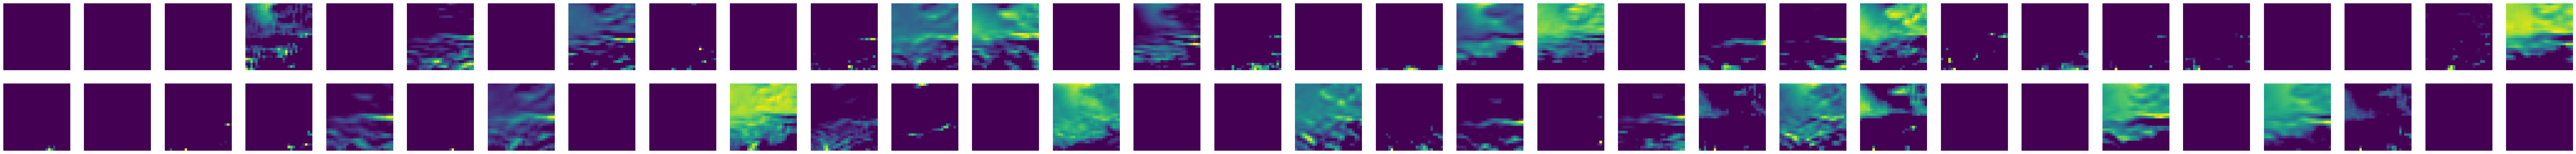

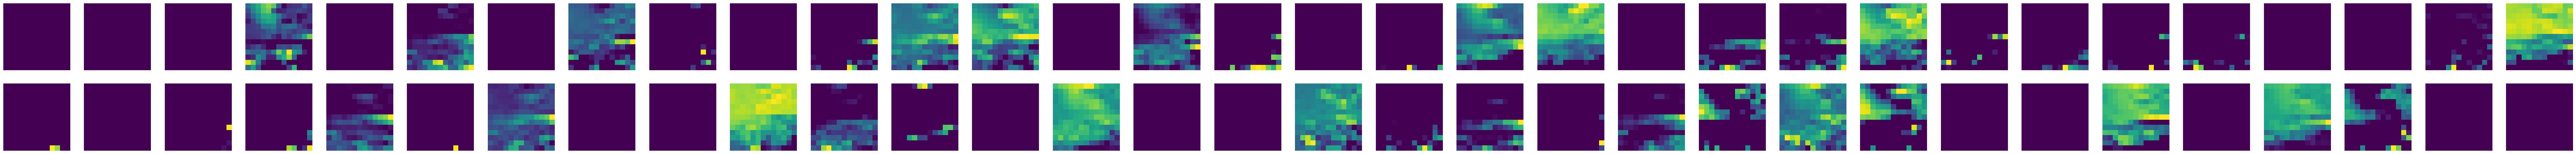

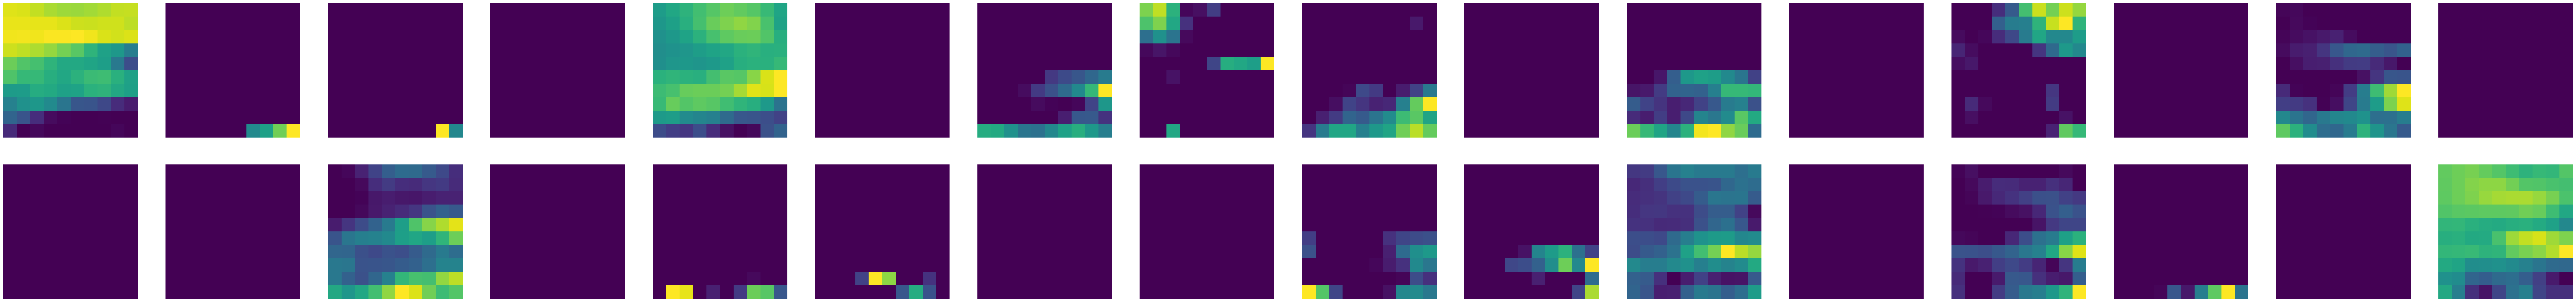

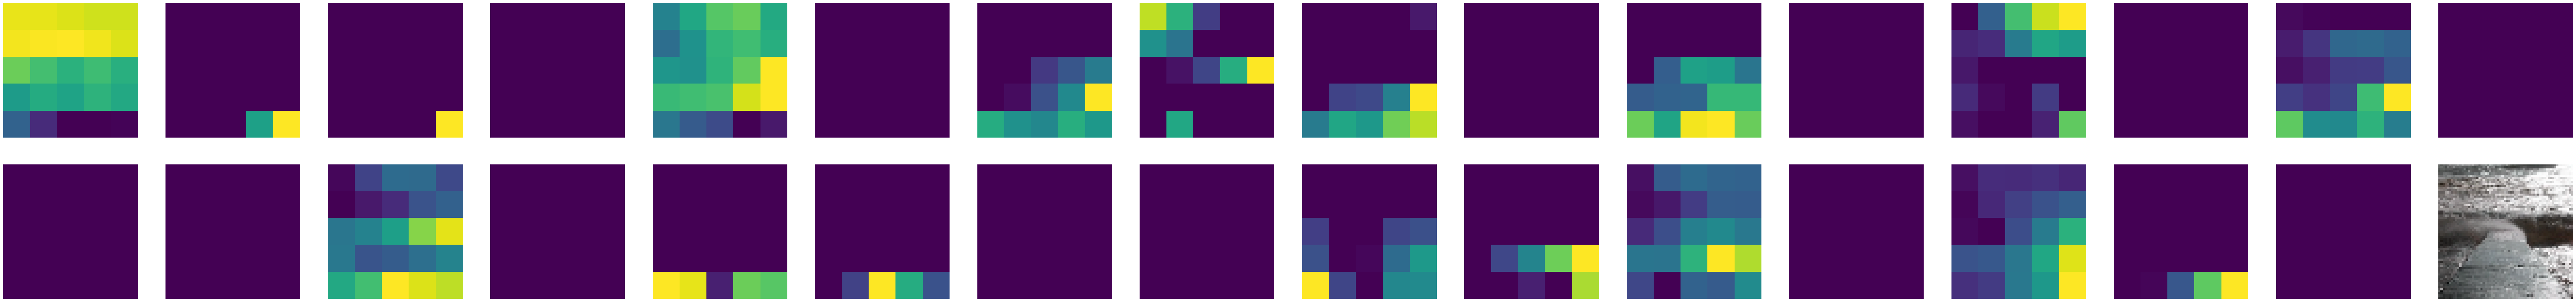

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 34ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:29.093764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 31ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:29.473191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 35ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32


2023-01-29 13:58:30.027324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
2Pooling
1/1 [==============================] - 0s 39ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32


2023-01-29 13:58:30.322976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------


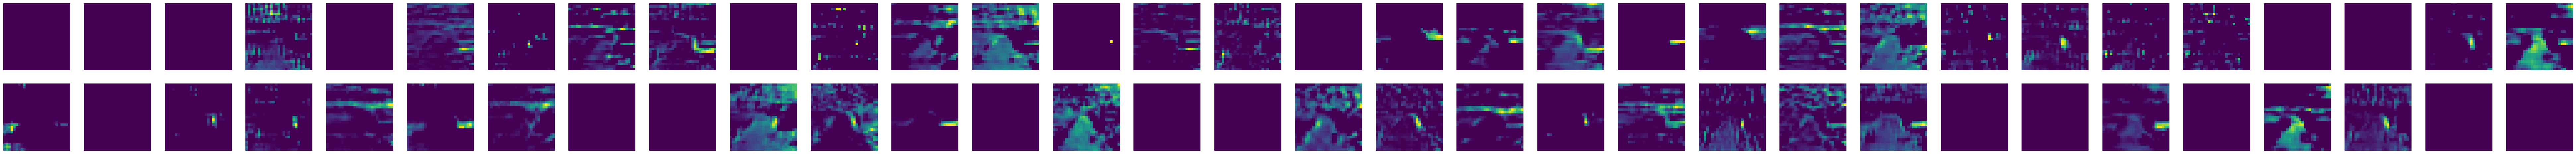

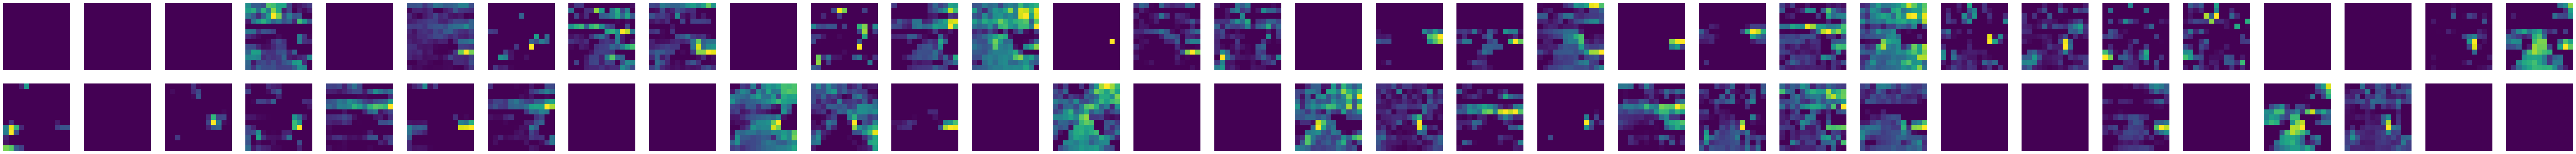

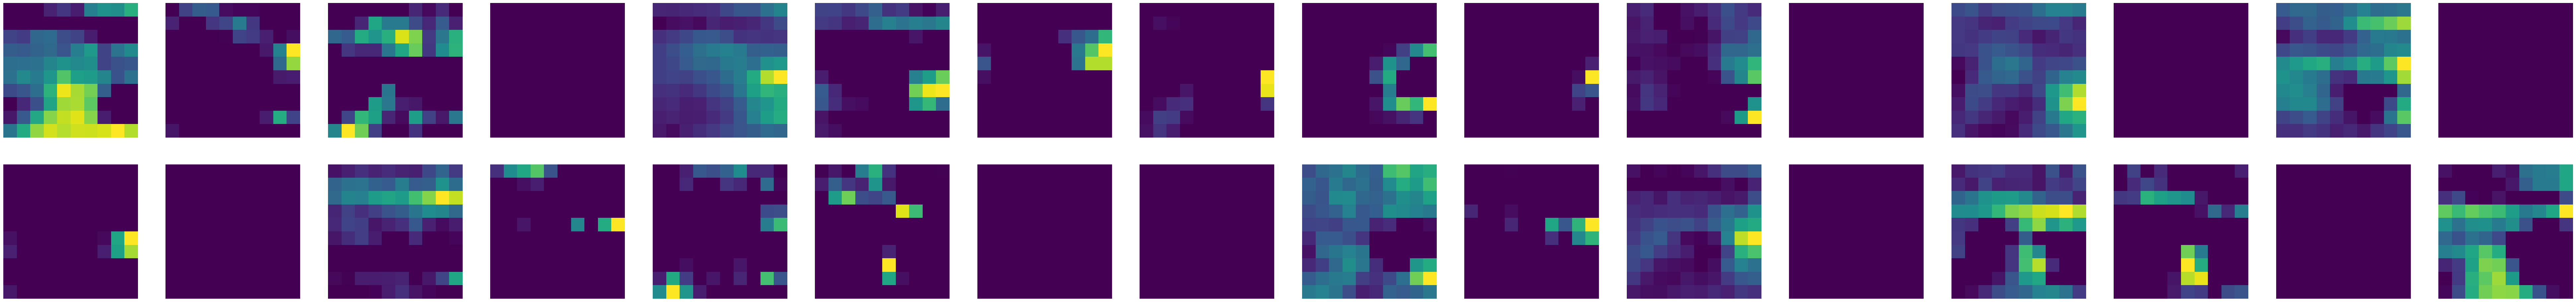

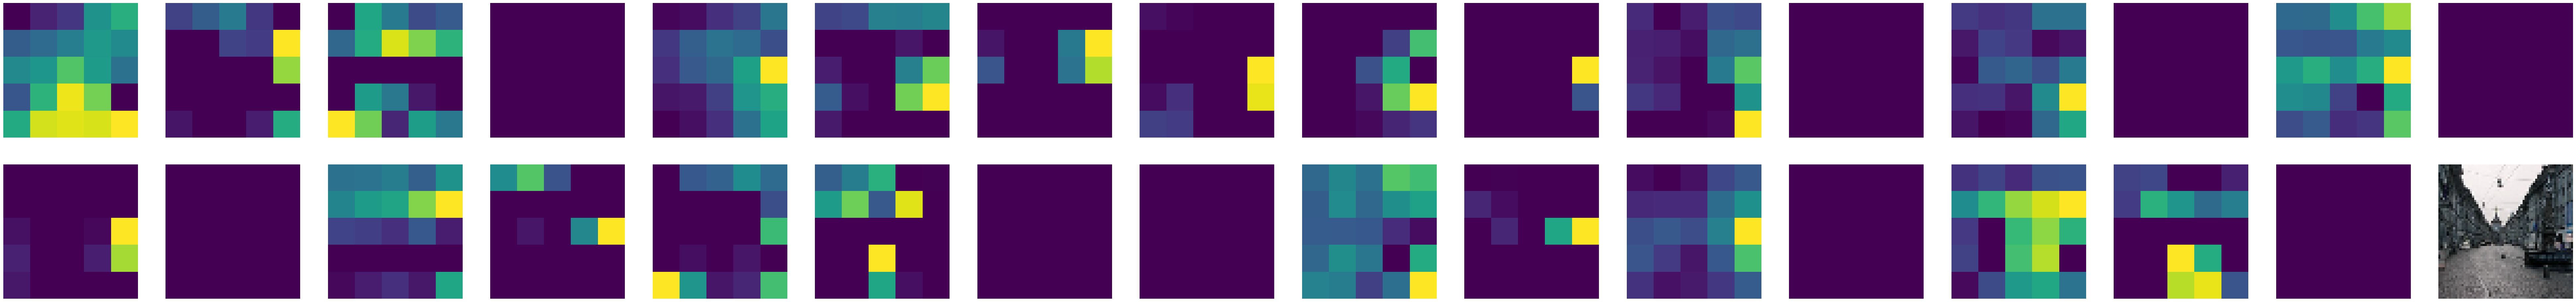

-----------------------------------------------------
1convolutionnal layer
1/1 [==============================] - 0s 41ms/step
conv2d_1 | Features Shape: (1, 27, 27, 64)
Dimension 64


2023-01-29 13:58:32.544298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


--------
1Pooling
1/1 [==============================] - 0s 30ms/step
max_pooling2d_1 | Features Shape: (1, 13, 13, 64)
Dimension 64


2023-01-29 13:58:33.134841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


-----------------------------------------------------
-----------------------------------------------------
2convolutionnal layer
1/1 [==============================] - 0s 37ms/step
conv2d_2 | Features Shape: (1, 10, 10, 32)
Dimension 32
--------
2Pooling


2023-01-29 13:58:33.560239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-01-29 13:58:33.759388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 37ms/step
max_pooling2d_2 | Features Shape: (1, 5, 5, 32)
Dimension 32
-----------------------------------------------------


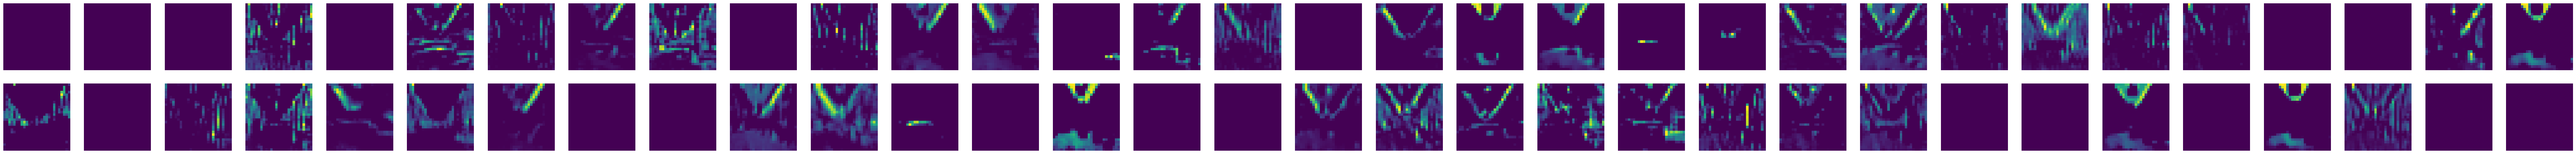

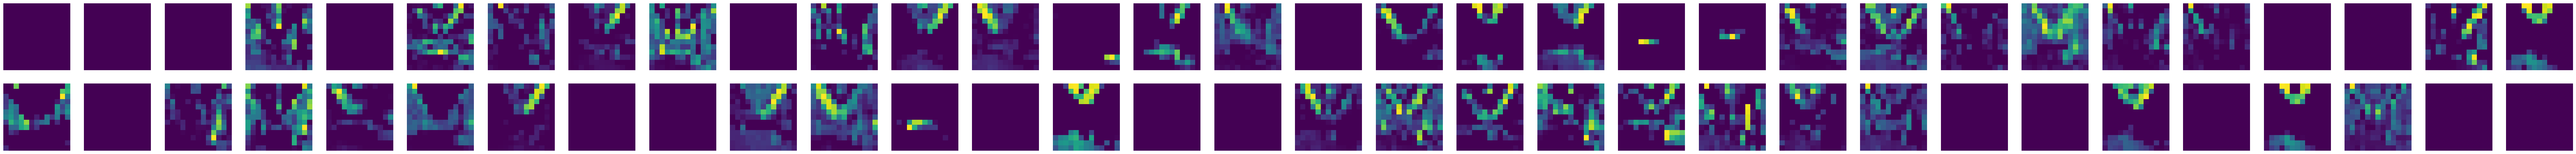

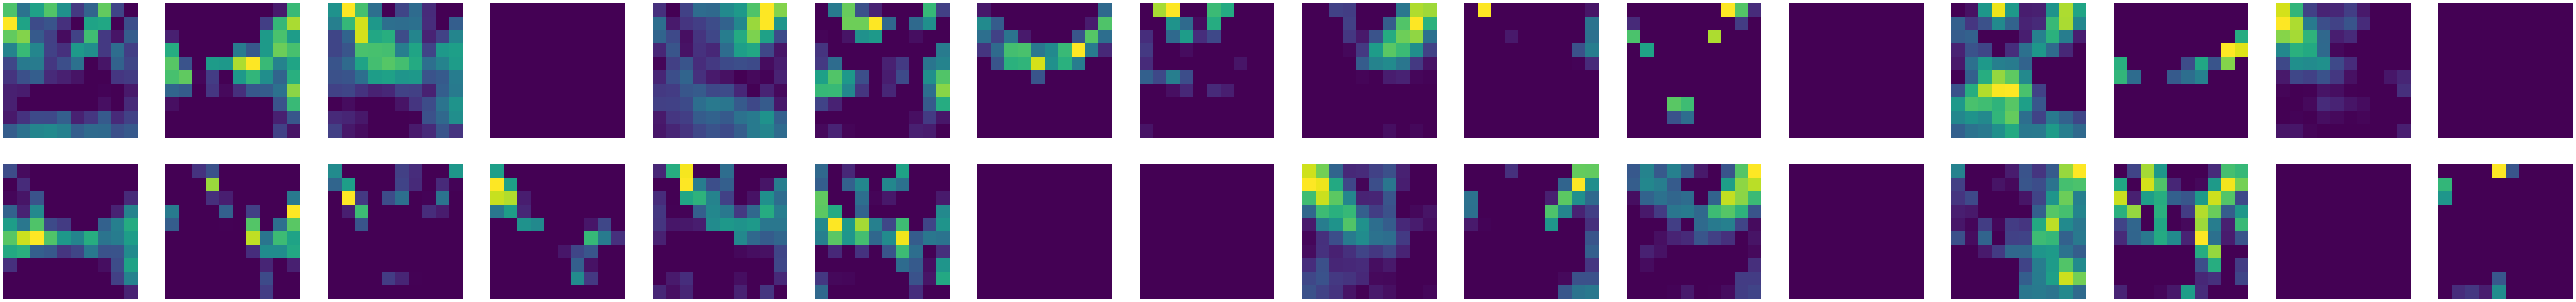

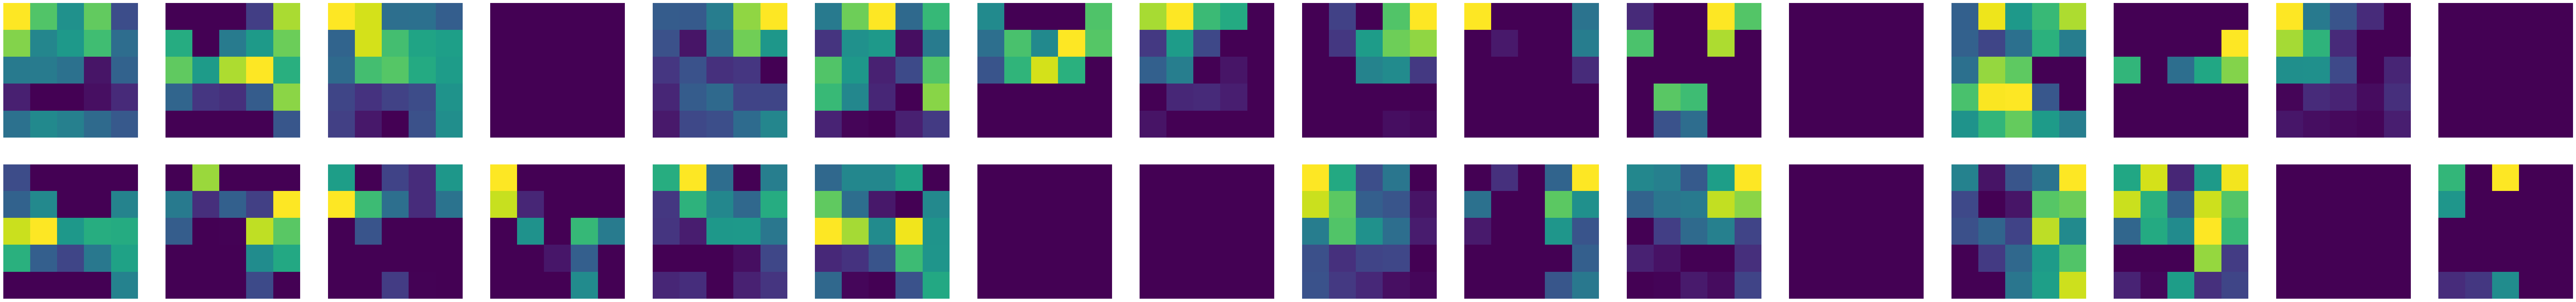

In [19]:
def display_image_filtered(name_image,model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1)  
    img=cv2.resize(image,IMAGE_SIZE)              
    input_img= np.expand_dims(img, axis=0)      
    f=feature_map_1.predict(input_img) 
    dim = f.shape[3]
    print(f'{layer_name} | Features Shape: {f.shape}')
    print(f'Dimension {dim}')
    fig= plt.figure(figsize=(100,100))
    if not os.path.exists(f'results_{name_image}'):
        os.makedirs(f'results_{name_image}')        
    for i in range(dim):
        ax = fig.add_subplot(int(dim/2),int(dim/2),i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i])
        plt.imsave(f'results_{name_image}/{name_image}_{layer_name}_{i}.jpg',f[0,:,:,i])
num = 1
for name in ['building','forest','glacier','mountain','sea','street']:
    if name == 'building':
        image = img_building
    elif name == 'forest':
        image = img_forest
    elif name == 'glacier':
        image = img_glacier
    elif name == 'mountain':
        image = img_mountain
    elif name == 'sea':
        image = img_sea
    elif name == 'street':
        image = img_street
    plt.axis('off')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    for i in range(0,2):
        if num == 0 and i==0:
            print('-----------------------------------------------------')
            print(f'{i+1}convolutionnal layer')
            display_image_filtered(name,model,f'conv2d',image)
            print('--------')
            print(f'{i-1}Pooling')
            display_image_filtered(name,model,f'max_pooling2d',image)
            print('-----------------------------------------------------')
        else:
            print('-----------------------------------------------------')
            print(f'{i+1}convolutionnal layer')
            display_image_filtered(name,model,f'conv2d_{num+i}',image)
            print('--------')
            print(f'{i+1}Pooling')
            display_image_filtered(name,model,f'max_pooling2d_{num+i}',image)
            print('-----------------------------------------------------')
     

In [20]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

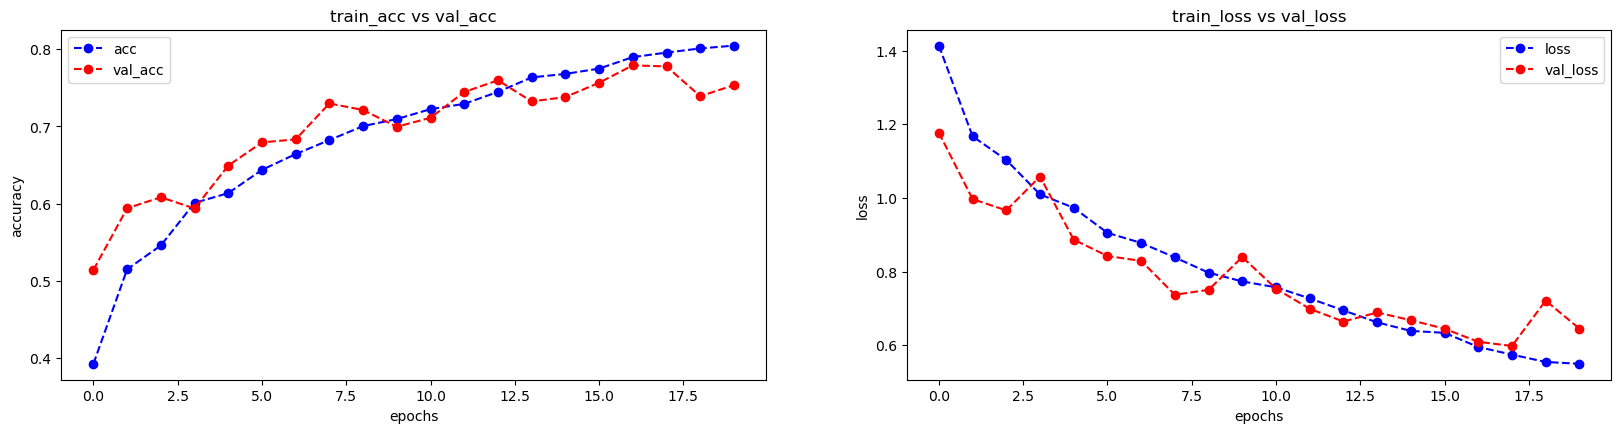

In [21]:
plot_accuracy_loss(history)

### On va evaluer le modèle sur l'ensemble de test

In [22]:
test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 2s 17ms/step - loss: 0.6556 - accuracy: 0.7607


Nous obtenons une précision de 0,736 sur le jeu de test. On a un léger sous-ajustement :(

Voyons comment le classificateur se comporte sur des images aléatoires.

 9/94 [=>............................] - ETA: 1s

2023-01-29 13:58:39.069114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 15ms/step


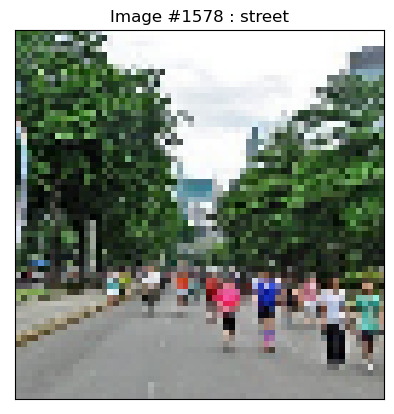

In [23]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

##  Analyse des erreurs

On va essayer de voir quels images sont mal classifiées par le Réseau de neuronnes

In [24]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        affichage de 25 images mal classifiées,
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Quelques exemples d'images m'al classifiées:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)


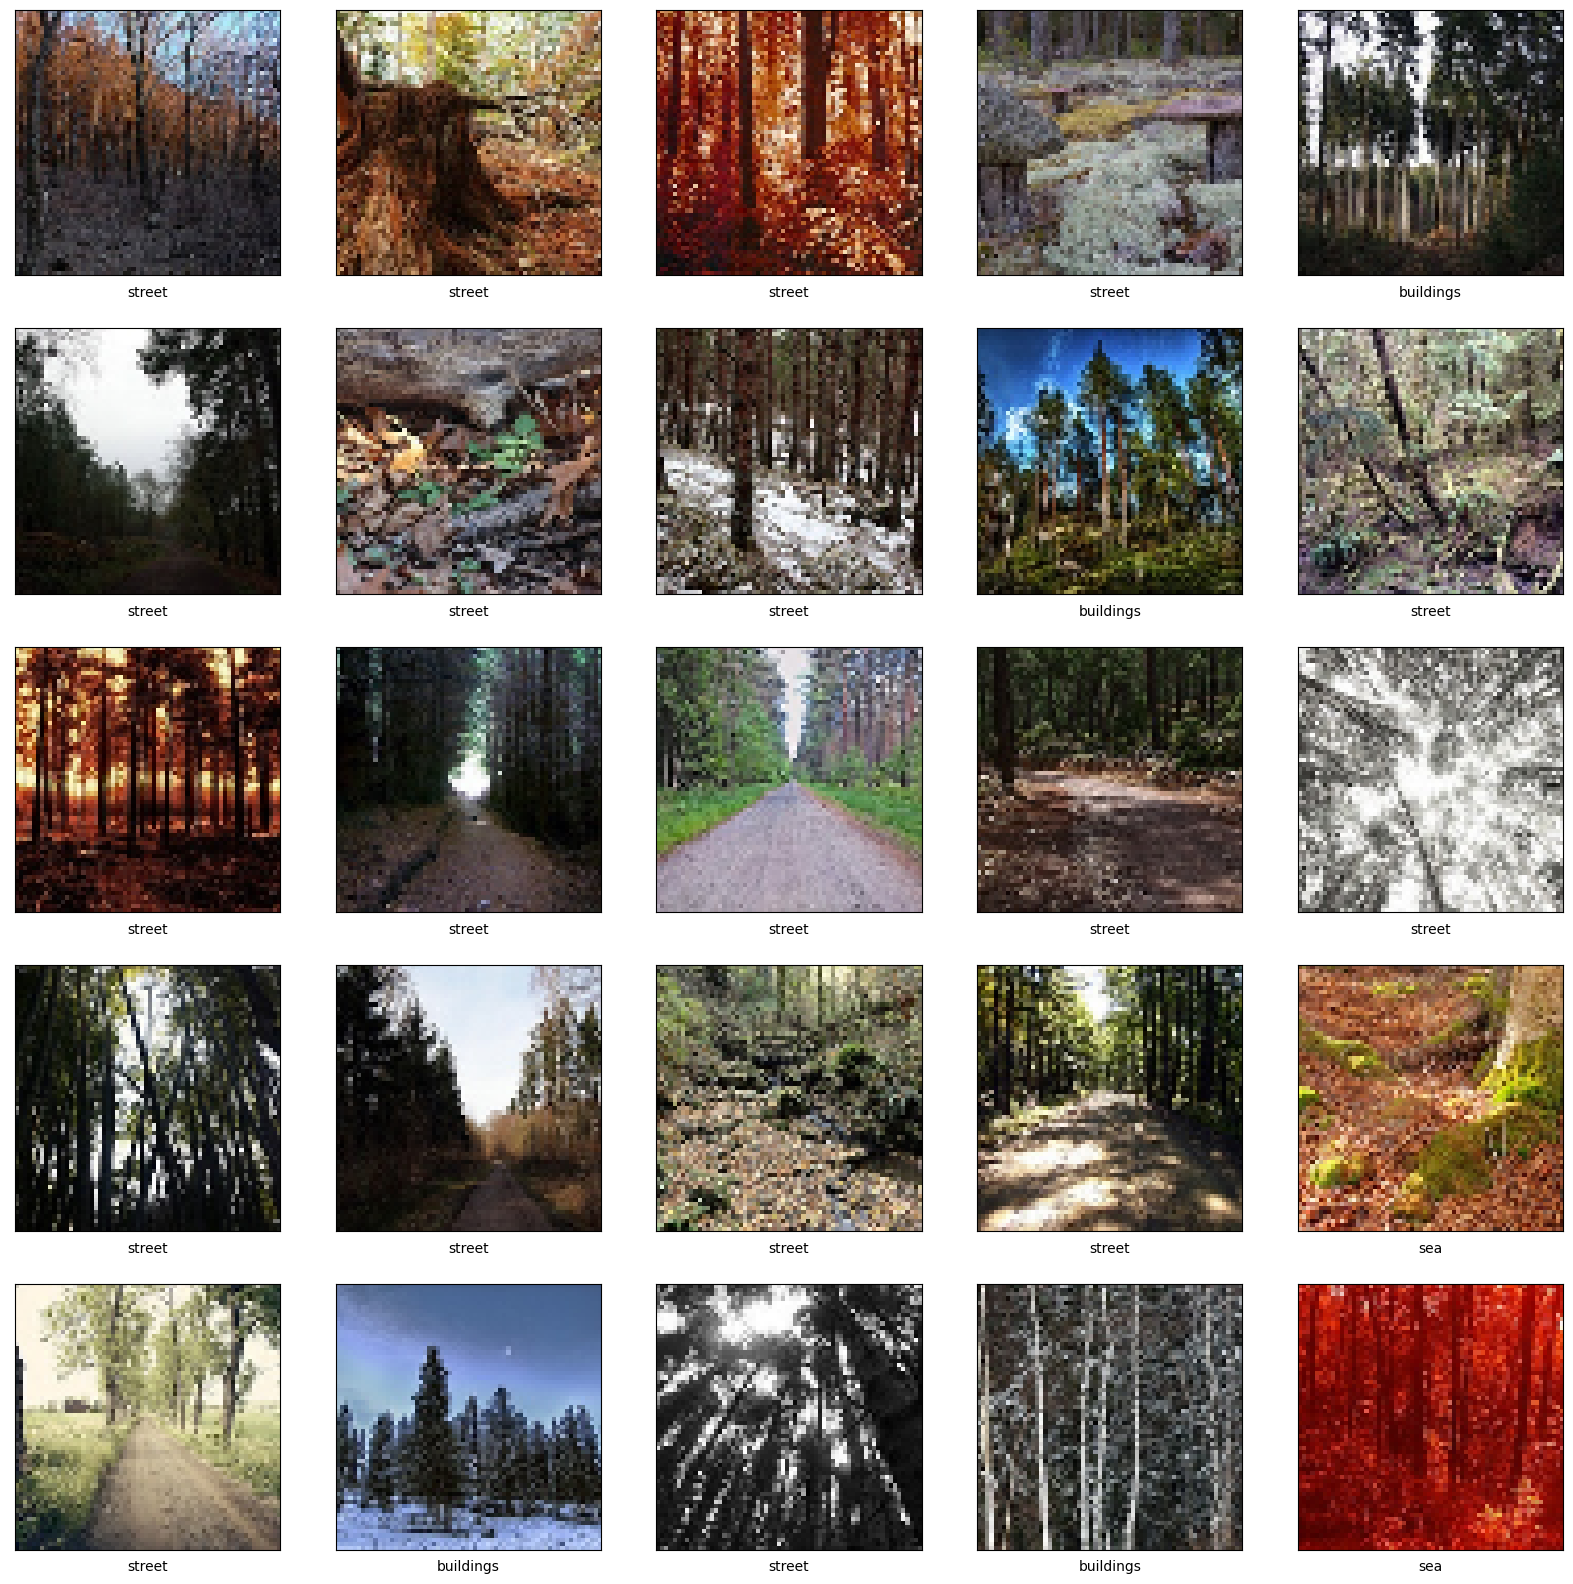

In [25]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

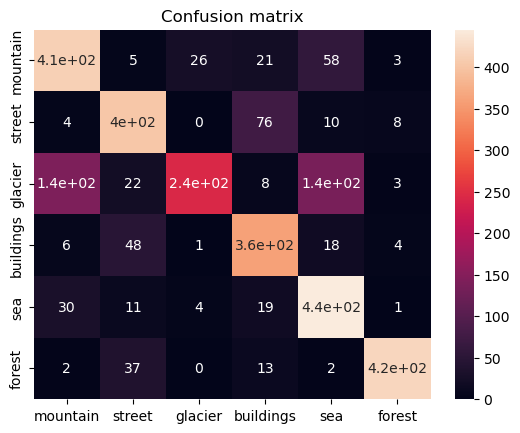

In [26]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## Conclusion: Le réseau classe mal deux catégories d'images.
Il classe mal les catégories street et buildings. Ce qui est compréhensible puisqu'il y a des batiments dans les photos de rues.

Il classe mal egalement sea, glacier et mountain. 

En revanche, il classe de façon très précise les images de forêts.

# Extraction de caractéristiques avec VGG ImageNet

On peut extraire des caractéristiques a partir du VVG16, il algorithme déja entrainé pour classifier des images.

In [27]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

In [28]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

  3/439 [..............................] - ETA: 12s 

2023-01-29 13:58:42.124744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 4s 45ms/step


## Visualisation des caractéristiques à travers PCA

In [29]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

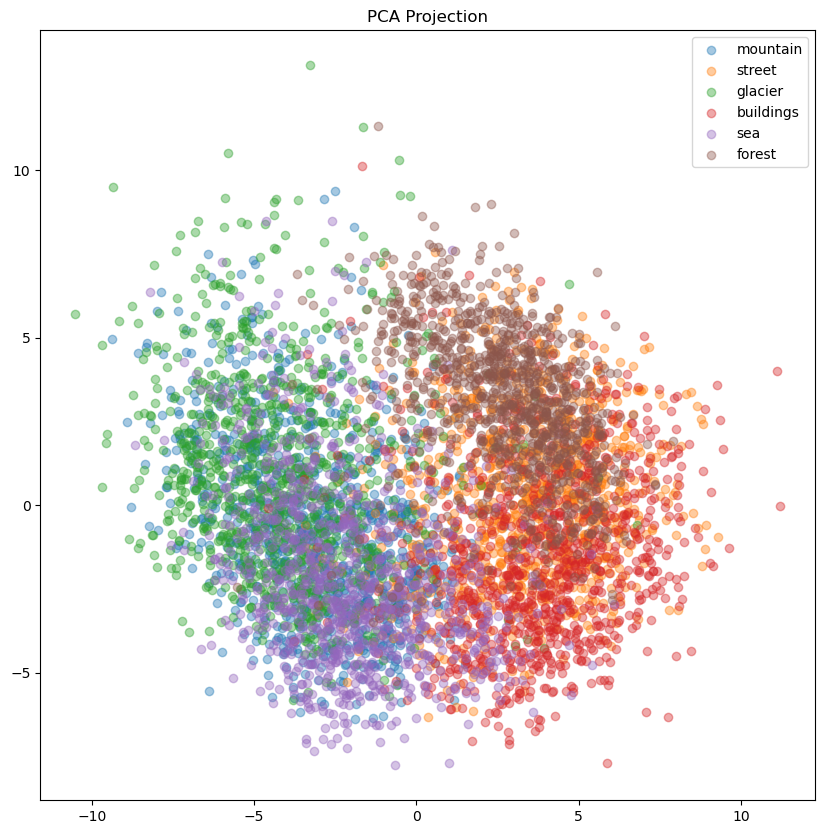

In [31]:
### Figures

plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

On peut identifier des clusters grâce au PCA. Les clusters correspondent plus ou moins aux labels.

On peut voir que les points de glacier et de montagne sont très proches les uns des autres, car le VGG16 les considère comme très similaires.

On voit qu'il n'y a pas de distinction entre buildings et street.

## Transfer Learning avec le VGG16

Entraînons un simple réseau de neurones à une couche sur les fonctionnalités extraites de VGG.

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.25)

Epoch 1/15
 6/83 [=>............................] - ETA: 1s - loss: 1.5070 - accuracy: 0.4271 

2023-01-29 13:59:06.999572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 9ms/step - loss: 0.7301 - accuracy: 0.7343 - val_loss: 0.5304 - val_accuracy: 0.8119
Epoch 2/15
 1/83 [..............................] - ETA: 0s - loss: 0.4297 - accuracy: 0.8672

2023-01-29 13:59:07.685461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 1s 6ms/step - loss: 0.4970 - accuracy: 0.8219 - val_loss: 0.4865 - val_accuracy: 0.8284
Epoch 3/15
83/83 [==============================] - 1s 6ms/step - loss: 0.4464 - accuracy: 0.8380 - val_loss: 0.4753 - val_accuracy: 0.8287
Epoch 4/15
83/83 [==============================] - 1s 7ms/step - loss: 0.4178 - accuracy: 0.8506 - val_loss: 0.4555 - val_accuracy: 0.8324
Epoch 5/15
83/83 [==============================] - 1s 7ms/step - loss: 0.3843 - accuracy: 0.8617 - val_loss: 0.4564 - val_accuracy: 0.8376
Epoch 6/15
83/83 [==============================] - 1s 7ms/step - loss: 0.3601 - accuracy: 0.8727 - val_loss: 0.4553 - val_accuracy: 0.8384
Epoch 7/15
83/83 [==============================] - 1s 7ms/step - loss: 0.3474 - accuracy: 0.8768 - val_loss: 0.4454 - val_accuracy: 0.8373
Epoch 8/15
83/83 [==============================] - 1s 6ms/step - loss: 0.3274 - accuracy: 0.8856 - val_loss: 0.4542 - val_accuracy: 0.8384
Epoch 9/15
83/83 [=============

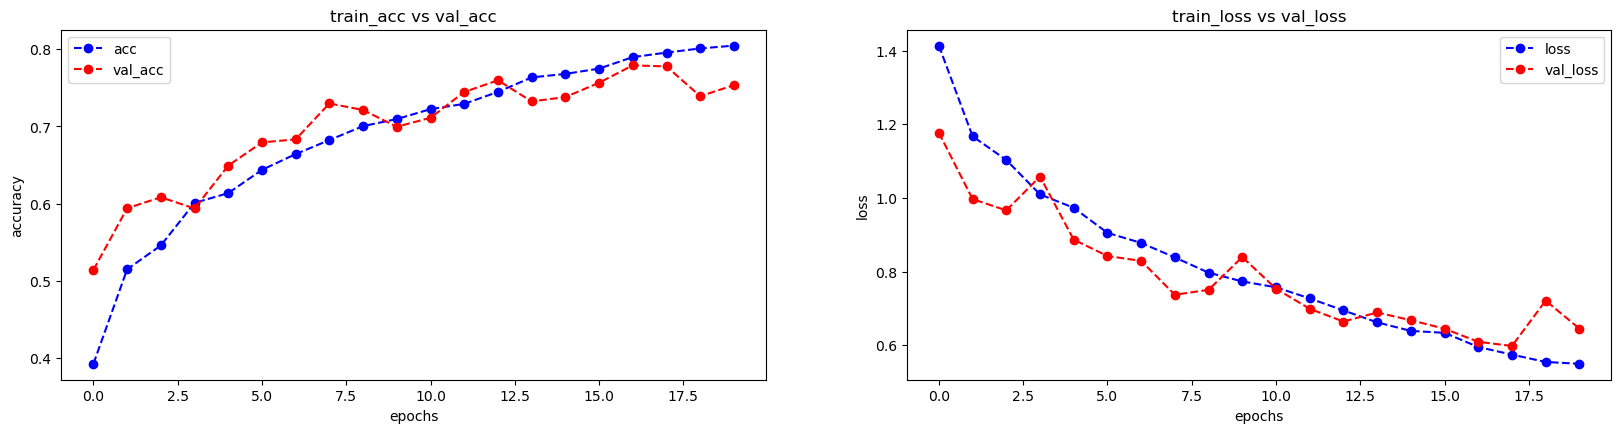

In [33]:
plot_accuracy_loss(history)

In [34]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 4ms/step - loss: 0.4702 - accuracy: 0.8373


Nous obtenons une précision d'environ 0,837 sur le simple ConvNet.

# Ensemble Neural Networks

In [35]:
np.random.seed(seed=1997)
# Nombre d'estimateurs
n_estimators = 10
#Proporition d'echantillon utilisée pour entrainer chaque estimateur

max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

Chaque réseau de neurones sera formé sur des sous-ensembles aléatoires du dataset train. Chaque sous-ensemble contient max_samples échantillons.

In [36]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [37]:
histories = []

for i in range(n_estimators):
    # Entrainement de chaque modele sur une partie du dataset train
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.25))

Epoch 1/10
 8/66 [==>...........................] - ETA: 0s - loss: 1.4512 - accuracy: 0.4746 

2023-01-29 14:02:13.515207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7486 - accuracy: 0.7281 - val_loss: 0.5576 - val_accuracy: 0.8030
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.5328 - accuracy: 0.8125

2023-01-29 14:02:14.089919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4775 - accuracy: 0.8323 - val_loss: 0.4793 - val_accuracy: 0.8318
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4003 - accuracy: 0.8621 - val_loss: 0.4852 - val_accuracy: 0.8336
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3601 - accuracy: 0.8766 - val_loss: 0.4470 - val_accuracy: 0.8489
Epoch 5/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3169 - accuracy: 0.8932 - val_loss: 0.4258 - val_accuracy: 0.8582
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2918 - accuracy: 0.9018 - val_loss: 0.4135 - val_accuracy: 0.8621
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2642 - accuracy: 0.9121 - val_loss: 0.4001 - val_accuracy: 0.8707
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2380 - accuracy: 0.9221 - val_loss: 0.4178 - val_accuracy: 0.8650
Epoch 9/10
66/66 [=============

2023-01-29 14:02:18.221773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7992 - accuracy: 0.7071 - val_loss: 0.5398 - val_accuracy: 0.8030
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.5700 - accuracy: 0.7812

2023-01-29 14:02:18.757123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4829 - accuracy: 0.8302 - val_loss: 0.4637 - val_accuracy: 0.8415
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4185 - accuracy: 0.8536 - val_loss: 0.4365 - val_accuracy: 0.8479
Epoch 4/10
66/66 [==============================] - 1s 8ms/step - loss: 0.3717 - accuracy: 0.8741 - val_loss: 0.4068 - val_accuracy: 0.8600
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3361 - accuracy: 0.8792 - val_loss: 0.3900 - val_accuracy: 0.8678
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2959 - accuracy: 0.9026 - val_loss: 0.3890 - val_accuracy: 0.8650
Epoch 7/10
66/66 [==============================] - 1s 8ms/step - loss: 0.2762 - accuracy: 0.9107 - val_loss: 0.3751 - val_accuracy: 0.8696
Epoch 8/10
66/66 [==============================] - 1s 9ms/step - loss: 0.2465 - accuracy: 0.9191 - val_loss: 0.3839 - val_accuracy: 0.8703
Epoch 9/10
66/66 [=============

2023-01-29 14:02:23.215460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.8475 - accuracy: 0.6894 - val_loss: 0.5728 - val_accuracy: 0.8073
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4979 - accuracy: 0.8281

2023-01-29 14:02:23.752706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4938 - accuracy: 0.8236 - val_loss: 0.5005 - val_accuracy: 0.8172
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4155 - accuracy: 0.8529 - val_loss: 0.4616 - val_accuracy: 0.8340
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3776 - accuracy: 0.8685 - val_loss: 0.4633 - val_accuracy: 0.8333
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3404 - accuracy: 0.8814 - val_loss: 0.4335 - val_accuracy: 0.8468
Epoch 6/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3060 - accuracy: 0.9011 - val_loss: 0.4127 - val_accuracy: 0.8539
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2791 - accuracy: 0.9076 - val_loss: 0.4017 - val_accuracy: 0.8643
Epoch 8/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2640 - accuracy: 0.9137 - val_loss: 0.4173 - val_accuracy: 0.8557
Epoch 9/10
66/66 [=============

2023-01-29 14:02:28.513327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7543 - accuracy: 0.7340 - val_loss: 0.5355 - val_accuracy: 0.8058
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4805 - accuracy: 0.7578

2023-01-29 14:02:29.040434: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4646 - accuracy: 0.8376 - val_loss: 0.4828 - val_accuracy: 0.8254
Epoch 3/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3990 - accuracy: 0.8587 - val_loss: 0.4572 - val_accuracy: 0.8429
Epoch 4/10
66/66 [==============================] - 1s 8ms/step - loss: 0.3509 - accuracy: 0.8831 - val_loss: 0.4259 - val_accuracy: 0.8522
Epoch 5/10
66/66 [==============================] - 0s 8ms/step - loss: 0.3158 - accuracy: 0.8943 - val_loss: 0.4054 - val_accuracy: 0.8589
Epoch 6/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2824 - accuracy: 0.9039 - val_loss: 0.4038 - val_accuracy: 0.8596
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2615 - accuracy: 0.9116 - val_loss: 0.3945 - val_accuracy: 0.8714
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2455 - accuracy: 0.9169 - val_loss: 0.4015 - val_accuracy: 0.8614
Epoch 9/10
66/66 [=============

2023-01-29 14:02:33.347465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7640 - accuracy: 0.7192 - val_loss: 0.5350 - val_accuracy: 0.8051
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4456 - accuracy: 0.8359

2023-01-29 14:02:33.880904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 7ms/step - loss: 0.4831 - accuracy: 0.8258 - val_loss: 0.4912 - val_accuracy: 0.8219
Epoch 3/10
66/66 [==============================] - 0s 7ms/step - loss: 0.4211 - accuracy: 0.8527 - val_loss: 0.4426 - val_accuracy: 0.8361
Epoch 4/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3687 - accuracy: 0.8743 - val_loss: 0.4168 - val_accuracy: 0.8489
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3314 - accuracy: 0.8895 - val_loss: 0.4061 - val_accuracy: 0.8497
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3078 - accuracy: 0.9002 - val_loss: 0.3939 - val_accuracy: 0.8568
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2806 - accuracy: 0.9088 - val_loss: 0.3958 - val_accuracy: 0.8589
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2613 - accuracy: 0.9144 - val_loss: 0.3963 - val_accuracy: 0.8593
Epoch 9/10
66/66 [=============

2023-01-29 14:02:38.012157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7483 - accuracy: 0.7285 - val_loss: 0.5083 - val_accuracy: 0.8215
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4484 - accuracy: 0.8672

2023-01-29 14:02:38.522093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4703 - accuracy: 0.8392 - val_loss: 0.4625 - val_accuracy: 0.8365
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4037 - accuracy: 0.8601 - val_loss: 0.4228 - val_accuracy: 0.8522
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3716 - accuracy: 0.8710 - val_loss: 0.4274 - val_accuracy: 0.8454
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3197 - accuracy: 0.8910 - val_loss: 0.3798 - val_accuracy: 0.8703
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2867 - accuracy: 0.9042 - val_loss: 0.3692 - val_accuracy: 0.8735
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2644 - accuracy: 0.9140 - val_loss: 0.3633 - val_accuracy: 0.8799
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2383 - accuracy: 0.9248 - val_loss: 0.3587 - val_accuracy: 0.8771
Epoch 9/10
66/66 [=============

2023-01-29 14:02:42.570877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 9ms/step - loss: 0.7282 - accuracy: 0.7382 - val_loss: 0.5260 - val_accuracy: 0.8098
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4458 - accuracy: 0.8359

2023-01-29 14:02:43.118037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4769 - accuracy: 0.8347 - val_loss: 0.4868 - val_accuracy: 0.8237
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4036 - accuracy: 0.8587 - val_loss: 0.4740 - val_accuracy: 0.8276
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3510 - accuracy: 0.8830 - val_loss: 0.4194 - val_accuracy: 0.8586
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3202 - accuracy: 0.8913 - val_loss: 0.4165 - val_accuracy: 0.8546
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2863 - accuracy: 0.9061 - val_loss: 0.4195 - val_accuracy: 0.8561
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2643 - accuracy: 0.9159 - val_loss: 0.3913 - val_accuracy: 0.8675
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2308 - accuracy: 0.9296 - val_loss: 0.3776 - val_accuracy: 0.8700
Epoch 9/10
66/66 [=============

2023-01-29 14:02:47.181492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 10ms/step - loss: 0.7147 - accuracy: 0.7420 - val_loss: 0.5545 - val_accuracy: 0.8030
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.4596 - accuracy: 0.7969

2023-01-29 14:02:47.740886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 6ms/step - loss: 0.4563 - accuracy: 0.8380 - val_loss: 0.4646 - val_accuracy: 0.8354
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3900 - accuracy: 0.8637 - val_loss: 0.4382 - val_accuracy: 0.8454
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3376 - accuracy: 0.8822 - val_loss: 0.4018 - val_accuracy: 0.8536
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2908 - accuracy: 0.9032 - val_loss: 0.3796 - val_accuracy: 0.8671
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2612 - accuracy: 0.9153 - val_loss: 0.3727 - val_accuracy: 0.8739
Epoch 7/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2386 - accuracy: 0.9215 - val_loss: 0.3579 - val_accuracy: 0.8810
Epoch 8/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2120 - accuracy: 0.9303 - val_loss: 0.3597 - val_accuracy: 0.8725
Epoch 9/10
66/66 [=============

2023-01-29 14:02:51.895033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 10ms/step - loss: 0.7467 - accuracy: 0.7309 - val_loss: 0.5139 - val_accuracy: 0.8187
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.5517 - accuracy: 0.8047

2023-01-29 14:02:52.455032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 7ms/step - loss: 0.4745 - accuracy: 0.8299 - val_loss: 0.4687 - val_accuracy: 0.8351
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4041 - accuracy: 0.8606 - val_loss: 0.4345 - val_accuracy: 0.8568
Epoch 4/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3599 - accuracy: 0.8741 - val_loss: 0.4158 - val_accuracy: 0.8614
Epoch 5/10
66/66 [==============================] - 0s 7ms/step - loss: 0.3228 - accuracy: 0.8887 - val_loss: 0.3983 - val_accuracy: 0.8682
Epoch 6/10
66/66 [==============================] - 0s 7ms/step - loss: 0.2940 - accuracy: 0.9000 - val_loss: 0.4076 - val_accuracy: 0.8600
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2739 - accuracy: 0.9083 - val_loss: 0.3740 - val_accuracy: 0.8817
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2461 - accuracy: 0.9201 - val_loss: 0.3768 - val_accuracy: 0.8796
Epoch 9/10
66/66 [=============

2023-01-29 14:02:56.661316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 10ms/step - loss: 0.7426 - accuracy: 0.7317 - val_loss: 0.5255 - val_accuracy: 0.8044
Epoch 2/10
 1/66 [..............................] - ETA: 0s - loss: 0.5997 - accuracy: 0.8047

2023-01-29 14:02:57.221250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 0s 7ms/step - loss: 0.4731 - accuracy: 0.8350 - val_loss: 0.4515 - val_accuracy: 0.8375
Epoch 3/10
66/66 [==============================] - 0s 6ms/step - loss: 0.4121 - accuracy: 0.8553 - val_loss: 0.4296 - val_accuracy: 0.8454
Epoch 4/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3625 - accuracy: 0.8761 - val_loss: 0.4196 - val_accuracy: 0.8504
Epoch 5/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3337 - accuracy: 0.8872 - val_loss: 0.3991 - val_accuracy: 0.8575
Epoch 6/10
66/66 [==============================] - 0s 6ms/step - loss: 0.3030 - accuracy: 0.8982 - val_loss: 0.3895 - val_accuracy: 0.8614
Epoch 7/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2801 - accuracy: 0.9075 - val_loss: 0.4057 - val_accuracy: 0.8632
Epoch 8/10
66/66 [==============================] - 0s 6ms/step - loss: 0.2676 - accuracy: 0.9087 - val_loss: 0.4412 - val_accuracy: 0.8440
Epoch 9/10
66/66 [=============

Nous agrégeons (unissons) les prédictions individuelles de chaque modèle pour former une prédiction finale.

In [38]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:01.259351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:01.489524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:01.722317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:01.942989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:02.160210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:02.391806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:02.619444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:02.844394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:03.069674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 0s 2ms/step


2023-01-29 14:03:03.293798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Nous devrions améliorer notre résultat car nous avons une variance plus faible.

In [39]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8383333333333334


# Fine Tuning VGG ImageNet

In [40]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [41]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

  3/439 [..............................] - ETA: 16s 

2023-01-29 14:03:38.702393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 4s 43ms/step


In [42]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (4, 4, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)

x = Conv2D(64, (2, 2), activation='relu')(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

new_model = Model(layer_input, x)

In [43]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
new_model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 4, 4, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 64)          131136    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 1, 1, 64)         0  

In [45]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=10, validation_split = 0.25)

Epoch 1/10


2023-01-29 14:04:38.658159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - ETA: 0s - loss: 0.7821 - accuracy: 0.6951

2023-01-29 14:04:43.926796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


83/83 [==============================] - 6s 68ms/step - loss: 0.7821 - accuracy: 0.6951 - val_loss: 0.4343 - val_accuracy: 0.8512
Epoch 2/10
83/83 [==============================] - 5s 65ms/step - loss: 0.3926 - accuracy: 0.8635 - val_loss: 0.4481 - val_accuracy: 0.8410
Epoch 3/10
83/83 [==============================] - 5s 64ms/step - loss: 0.3268 - accuracy: 0.8861 - val_loss: 0.3803 - val_accuracy: 0.8663
Epoch 4/10
83/83 [==============================] - 5s 64ms/step - loss: 0.2556 - accuracy: 0.9113 - val_loss: 0.3720 - val_accuracy: 0.8678
Epoch 5/10
83/83 [==============================] - 5s 64ms/step - loss: 0.1982 - accuracy: 0.9318 - val_loss: 0.3781 - val_accuracy: 0.8746
Epoch 6/10
83/83 [==============================] - 5s 64ms/step - loss: 0.1822 - accuracy: 0.9380 - val_loss: 0.4406 - val_accuracy: 0.8698
Epoch 7/10
83/83 [==============================] - 5s 64ms/step - loss: 0.1431 - accuracy: 0.9518 - val_loss: 0.4464 - val_accuracy: 0.8595
Epoch 8/10
83/83 [======

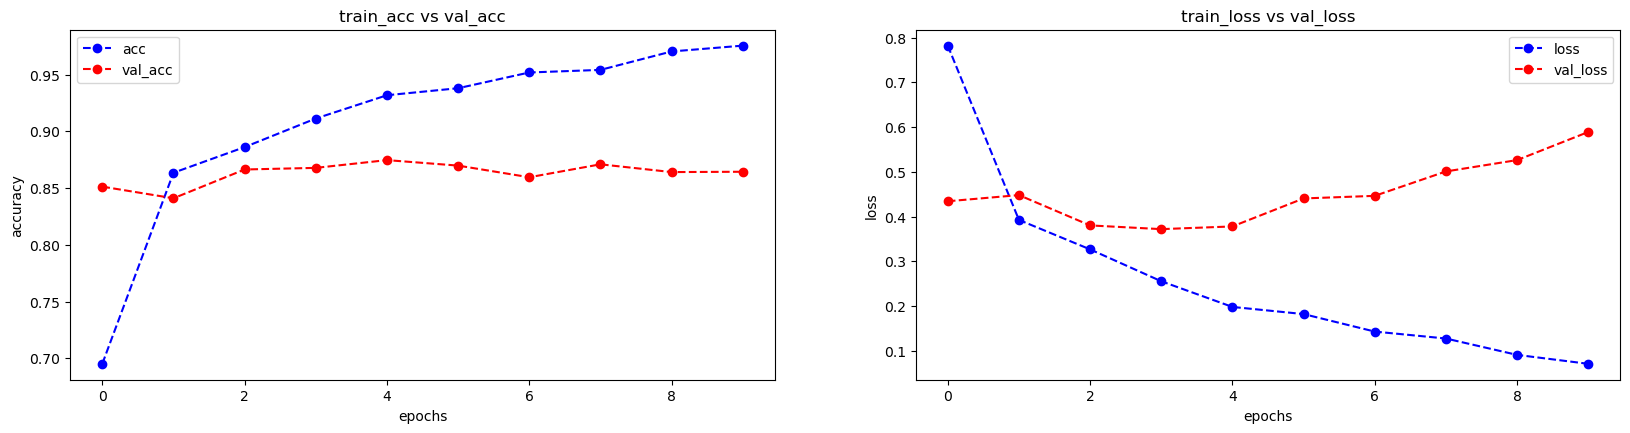

In [46]:
plot_accuracy_loss(history)

In [47]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

16/94 [====>.........................] - ETA: 0s

2023-01-29 14:05:32.949101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 8ms/step
Accuracy : 0.868
